In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

data = pd.read_csv('passos.csv', delimiter=';')
data.head()

,equation,answer,correct
0,x+15=45-2x,x-2x=45-15,0
1,x+15=45-2x,x-2x=45+15,0
2,x+15=45-2x,x+2x=45-15,1
3,x+15=45-2x,3x=30,1
4,x+15=45-2x,x=(30)/(3),1


In [2]:
# Connects to the PostgreSQL Database
engine = create_engine('postgresql://ppgca@postgres:5432/equations')

In [3]:
import re
# Creates column <equation_size> based on the # of digits
numbers_in_equation = data['equation'].apply(lambda x: len(re.findall('[0-9]+', x)))
data.insert(1, 'numbers_in_equation', numbers_in_equation)

In [4]:
data.head(10)

,equation,numbers_in_equation,answer,correct
0,x+15=45-2x,3,x-2x=45-15,0
1,x+15=45-2x,3,x-2x=45+15,0
2,x+15=45-2x,3,x+2x=45-15,1
3,x+15=45-2x,3,3x=30,1
4,x+15=45-2x,3,x=(30)/(3),1
5,x+15=45-2x,3,x=10,1
6,x+4=10,2,x=10-4,1
7,x+4=10,2,x=6,1
8,x+1=23,2,x=23-1,1
9,x+1=23,2,x=22,1


In [5]:
# Creates columns based on the # of arithmetic operations and brackes on the equation
additions = data['equation'].apply(lambda x: x.count('+'))
data.insert(2, 'additions', additions)

subtractions = data['equation'].apply(lambda x: x.count('-'))
data.insert(3, 'subtractions', subtractions)

multiplications = data['equation'].apply(lambda x: x.count('*'))
data.insert(4, 'multiplications', multiplications)

divisions = data['equation'].apply(lambda x: x.count('/'))
data.insert(5, 'divisions', divisions)

brackets = data['equation'].apply(lambda x: x.count(')'))
data.insert(5, 'brackets', brackets)

# For total count of operations
#operations_count = data['equation'].apply(lambda x: x.count('+'))

In [6]:
data.tail()

,equation,numbers_in_equation,additions,subtractions,multiplications,brackets,divisions,answer,correct
40242,10=3*(x-2)-(x-18),4,0,3,1,2,0,10=3x-6-x+18,1
40243,10=3*(x-2)-(x-18),4,0,3,1,2,0,x-3x=18-6-10,1
40244,10=3*(x-2)-(x-18),4,0,3,1,2,0,2x=2,0
40245,10=3*(x-2)-(x-18),4,0,3,1,2,0,x=1,0
40246,10=3*(x-2)-(x-18),4,0,3,1,2,0,x=-1,1


In [7]:
# Drop the column <answer>
data.drop(['answer'], axis=1, inplace=True)
data.tail()

,equation,numbers_in_equation,additions,subtractions,multiplications,brackets,divisions,correct
40242,10=3*(x-2)-(x-18),4,0,3,1,2,0,1
40243,10=3*(x-2)-(x-18),4,0,3,1,2,0,1
40244,10=3*(x-2)-(x-18),4,0,3,1,2,0,0
40245,10=3*(x-2)-(x-18),4,0,3,1,2,0,0
40246,10=3*(x-2)-(x-18),4,0,3,1,2,0,1


In [8]:
# Focus on the rows with 0 on the <correct> column
data = data.loc[data['correct'] == 0]
data.tail()

,equation,numbers_in_equation,additions,subtractions,multiplications,brackets,divisions,correct
40234,x+3*(x-1)-(x+9)=-147,4,2,3,1,2,0,0
40235,x+3*(x-1)-(x+9)=-147,4,2,3,1,2,0,0
40240,x+3*(x-1)-(x+9)=-147,4,2,3,1,2,0,0
40244,10=3*(x-2)-(x-18),4,0,3,1,2,0,0
40245,10=3*(x-2)-(x-18),4,0,3,1,2,0,0


In [9]:
# Now, remove the correct column, as it shall not be used during the clustering phase
data.drop(['correct'], axis=1, inplace=True)
data.tail()

,equation,numbers_in_equation,additions,subtractions,multiplications,brackets,divisions
40234,x+3*(x-1)-(x+9)=-147,4,2,3,1,2,0
40235,x+3*(x-1)-(x+9)=-147,4,2,3,1,2,0
40240,x+3*(x-1)-(x+9)=-147,4,2,3,1,2,0
40244,10=3*(x-2)-(x-18),4,0,3,1,2,0
40245,10=3*(x-2)-(x-18),4,0,3,1,2,0


In [10]:
# Creates an equations_vector to hold equations and drops it from the main dataframe
equations_vector = data[['equation']]
equations_vector.tail()

data.drop(['equation'], axis=1, inplace=True)

In [11]:
data.tail()

,numbers_in_equation,additions,subtractions,multiplications,brackets,divisions
40234,4,2,3,1,2,0
40235,4,2,3,1,2,0
40240,4,2,3,1,2,0
40244,4,0,3,1,2,0
40245,4,0,3,1,2,0


In [19]:
# Exports the dataframe to a PostgreSQL Database
data.to_sql(name='equations', con=engine, if_exists='replace')

# Exports the dataframe without equation as a csv
data.to_csv(r'passos_preprocessed.csv', index=False, header=True)

print('Pre-processed data exported both to the PostgreSQL Database and a .CSV file!')

Pre-processed data exported both to the PostgreSQL Database and a .CSV file!


In [20]:
# Applies k-means in order to get 3 clusters of similar equations that students most frequently get wrong
kmeans = KMeans(n_clusters=5).fit(data)
centroids = kmeans.cluster_centers_
print(centroids)

[[4.59448357 0.86267606 1.65610329 0.22593897 3.80046948 1.66197183]
 [4.91056641 0.80490229 2.61046704 1.73964889 1.8731368  0.00828089]
 [2.82133412 0.52101087 0.78489568 0.16279753 0.41375257 0.12342051]
 [7.12045455 2.21439394 2.11363636 2.03409091 2.49393939 0.13257576]
 [6.97826087 0.60144928 3.23550725 0.53623188 5.80072464 2.63224638]]


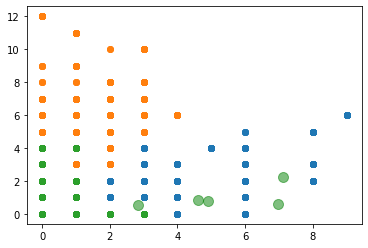

In [21]:
ax = plt.gca()
ax.scatter(data['brackets'], data['subtractions'])
ax.scatter(data['additions'], data['numbers_in_equation'])
ax.scatter(data['multiplications'], data['divisions'])
ax.scatter(centroids[:, 0], centroids[:, 1], c='green', s=100, alpha=0.5)
ax

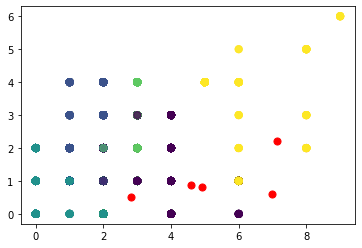

In [22]:
plt.scatter(data['brackets'], data['subtractions'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [23]:
X = StandardScaler().fit_transform(data)
X

array([[-0.87449262,  0.12941331, -0.63536408, -0.98595004, -1.22739028,
        -0.56156837],
       [-0.87449262,  0.12941331, -0.63536408, -0.98595004, -1.22739028,
        -0.56156837],
       [-1.43813221,  0.12941331, -1.43420338, -0.98595004, -1.22739028,
        -0.56156837],
       ...,
       [-0.31085304,  1.33864162,  0.96231451,  0.0887914 , -0.00226693,
        -0.56156837],
       [-0.31085304, -1.079815  ,  0.96231451,  0.0887914 , -0.00226693,
        -0.56156837],
       [-0.31085304, -1.079815  ,  0.96231451,  0.0887914 , -0.00226693,
        -0.56156837]])

In [24]:
#Set number of clusters at initialisation time
k_means = KMeans(n_clusters=12)

#Run the clustering algorithm
model = k_means.fit(X)
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [25]:
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)

In [26]:
# Calculating the silhouette coefficient
labels = k_means.labels_
metrics.silhouette_score(X, labels, metric = 'euclidean')

0.43076232795695824

In [27]:
# Calculating the Calinski Harabsz Score
metrics.calinski_harabasz_score(X, labels)

4685.921601651381

In [28]:
# Let us try this for another randomly chosen value i.e. n_clusters = 8
k_means_8 = KMeans(n_clusters=8)
model = k_means_8.fit(X)
y_hat_8 = k_means_8.predict(X)

In [29]:
# Once again, calculating the silhouette coefficient and CV scores
labels_8 = k_means_8.labels_
metrics.silhouette_score(X, labels_8, metric = 'euclidean')

0.3826646780772768

In [30]:
# Calculating the Calinski Harabsz Score
metrics.calinski_harabasz_score(X, labels_8)

5047.943408789723

In [31]:
# An elbow plot shows at what value of k the distance between the mean of a cluster and the other data points is lowest
# for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples 
# to the nearest cluster centre
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X)
    sum_of_squared_distances.append(k_means.inertia_)

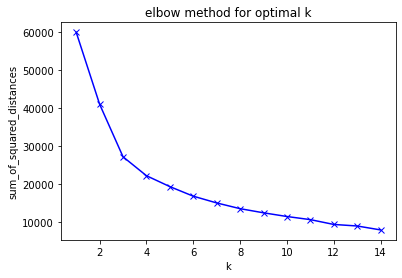

In [32]:
# It can be seen that the drop starts at 5, then 5 is the optimal number of clusters
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [33]:
# Verify by getting the Calinski Harabsz Score and the Silhouette Coefficient 
k_means_5 = KMeans(n_clusters=5)
model = k_means_5.fit(X)
y_hat_5 = k_means_5.predict(X)
labels_5 = k_means_5.labels_
metrics.silhouette_score(X, labels_5, metric = 'euclidean')
metrics.calinski_harabasz_score(X, labels_5)

5232.061398878166

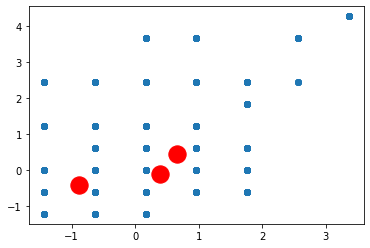

In [34]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,2], X[:,4])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()